In [11]:
!pip install catboost lightgbm xgboost
!pip install pandas numpy boto3

  Using cached catboost-1.2.5-cp310-cp310-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached lightgbm-4.5.0-py3-none-linux_x86_64.whl
  Using cached xgboost-2.1.1-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
Using cached catboost-1.2.5-cp310-cp310-manylinux2014_x86_64.whl (98.2 MB)
Using cached xgboost-2.1.1-py3-none-manylinux2014_x86_64.whl (4.5 MB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)


In [2]:
import pandas as pd
import boto3

s3 = boto3.client('s3')

# s3에서 데이터 로드
df = pd.read_csv('s3a://testawsbucket-01/output/merged_df.csv/part-00000-bbb9f4ff-1108-4b02-96b3-7188aa8d7ccf-c000.csv', low_memory=False)
print(df)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


                id_job    id_array_job  id_array_task         id_user  \
0       65590191436871  14108987335445            114  87509498710061   
1       64310074400647  61177129314629            600  42770088536256   
2       34191949612627  14108987335445            115  87509498710061   
3       21630303188597  61177129314629            601  42770088536256   
4       10343100598054  61177129314629            602  42770088536256   
...                ...             ...            ...             ...   
395909  75124122894379  16618712154521     4294967294   1706828023724   
395910  37802476679519  16618712154521     4294967294   1706828023724   
395911   9807128696900  38040778438207            109  48065336140816   
395912  42865228158509  38040778438207            110  48065336140816   
395913  36690157579853  38040778438207            111  48065336140816   

           kill_requid  nodes_alloc  cpus_req  derived_ec  exit_code  \
0       61026541062099            1        20      

In [3]:
# 결측치 채우기

df['gres_used'] = df['gres_used'].fillna(0)
df['model'] = df['model'].fillna('NONE')

In [4]:
# 범주형 변수 원-핫 인코딩
df = pd.get_dummies(df, columns=['constraints', 'partition', 'job_type'])


In [5]:
# 컬럼 이름 정제
df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

In [6]:
from sklearn.preprocessing import LabelEncoder

# 'model' 컬럼 라벨 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['model'])
df = df.drop('model', axis=1)

In [7]:
from sklearn.model_selection import train_test_split

X = df
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
!pip install imblearn

In [8]:
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# SMOTE로 소수 클래스 오버샘플링 (첫 번째 클래스를 제외한 나머지를 500으로 설정)
sampling_strategy = {i: 10000 for i in range(1, 27)}  # 1부터 26까지의 클래스에 대해 500으로 설정
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 다수 클래스 언더샘플링 (첫 번째 클래스는 500으로 유지)
#rus = RandomUnderSampler(sampling_strategy={0: 100000}, random_state=42)  # 첫 번째 클래스(0)의 수는 500으로 유지
#X_final, y_final = rus.fit_resample(X_resampled, y_resampled)

print("Initial dataset shape:", np.bincount(y_train))
print("Oversampled dataset shape:", np.bincount(y_resampled))
#print("Undersampled dataset shape:", np.bincount(y_final))

Initial dataset shape: [274724    115    112    111    116    120    115    103    107    108
    144     20     23    115    176    168     18     50     38     55
     39     76     65     22    133    127    139]
Oversampled dataset shape: [274724  10000  10000  10000  10000  10000  10000  10000  10000  10000
  10000  10000  10000  10000  10000  10000  10000  10000  10000  10000
  10000  10000  10000  10000  10000  10000  10000]


In [ ]:
import numpy as np
import lightgbm as lgb
import pickle
from sklearn.metrics import log_loss

# 1. LightGBM
train_data = lgb.Dataset(X_resampled, label=y_resampled)
valid_data = lgb.Dataset(X_valid, label=y_valid)

params_lgb = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': len(np.unique(y_train)),
    'learning_rate': 0.01,
    'n_estimators': 800,
    'num_leaves': 31
}

lgb_model = lgb.train(
    params_lgb,
    train_data,
    valid_sets=[valid_data],
    callbacks=[lgb.early_stopping(stopping_rounds=3), lgb.log_evaluation(period=100)]
)


with open('model/oversampling/lgb_model.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

# 예측 결과의 확률을 계산
lgb_pred = lgb_model.predict(X_valid, raw_score=False)

# 로그 손실 계산
lgb_log_loss = log_loss(y_valid, lgb_pred)
print(f'LightGBM Log Loss: {lgb_log_loss}')


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.114894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5424
[LightGBM] [Info] Number of data points in the train set: 534724, number of used features: 41
[LightGBM] [Info] Start training from score -0.665984
[LightGBM] [Info] Start training from score -3.979166
[LightGBM] [Info] Start training from score -3.979166
[LightGBM] [Info] Start training from score -3.979166
[LightGBM] [Info] Start training from score -3.979166
[LightGBM] [Info] Start training from score -3.979166
[LightGBM] [Info] Start training from score -3.979166
[LightGBM] [Info] Start training from score -3.979166
[LightGBM] [Info] Start training from score -3.979166
[LightGBM] [Info] Start training from score -3.979166
[LightGBM] [Info] Start training from score -3.979166
[LightGBM] [Info] Start training from score -3.97916

In [39]:
# 2. XGBoost
import xgboost as xgb

dtrain = xgb.DMatrix(X_resampled, label=y_resampled)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

params_xgb = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y_train)),
    'eval_metric': 'mlogloss',
    'max_depth': 6,
    'learning_rate': 0.01
}

xgb_model = xgb.train(params_xgb, dtrain, num_boost_round=800, 
                       evals=[(dvalid, 'eval')],
                       early_stopping_rounds=3, 
                       verbose_eval=True)

with open('model/oversampling/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)


xgb_pred = xgb_model.predict(dvalid)
xgb_log_loss = log_loss(y_valid, xgb_pred)
print(f'XGBoost Log Loss: {xgb_log_loss}')

[0]	eval-mlogloss:3.16242
[1]	eval-mlogloss:3.04582
[2]	eval-mlogloss:2.94216
[3]	eval-mlogloss:2.84881
[4]	eval-mlogloss:2.76387
[5]	eval-mlogloss:2.68594
[6]	eval-mlogloss:2.61393
[7]	eval-mlogloss:2.54700
[8]	eval-mlogloss:2.48447
[9]	eval-mlogloss:2.42581
[10]	eval-mlogloss:2.37054
[11]	eval-mlogloss:2.31831
[12]	eval-mlogloss:2.26880
[13]	eval-mlogloss:2.22173
[14]	eval-mlogloss:2.17689
[15]	eval-mlogloss:2.13408
[16]	eval-mlogloss:2.09311
[17]	eval-mlogloss:2.05385
[18]	eval-mlogloss:2.01615
[19]	eval-mlogloss:1.97989
[20]	eval-mlogloss:1.94499
[21]	eval-mlogloss:1.91133
[22]	eval-mlogloss:1.87883
[23]	eval-mlogloss:1.84743
[24]	eval-mlogloss:1.81704
[25]	eval-mlogloss:1.78762
[26]	eval-mlogloss:1.75910
[27]	eval-mlogloss:1.73144
[28]	eval-mlogloss:1.70458
[29]	eval-mlogloss:1.67848
[30]	eval-mlogloss:1.65310
[31]	eval-mlogloss:1.62842
[32]	eval-mlogloss:1.60438
[33]	eval-mlogloss:1.58095
[34]	eval-mlogloss:1.55813
[35]	eval-mlogloss:1.53586
[36]	eval-mlogloss:1.51410
[37]	eval-m

In [40]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import log_loss

# Pool 객체 생성
train_pool = Pool(X_resampled, y_resampled)
valid_pool = Pool(X_valid, y_valid)

# CatBoost 모델 설정
cat_model = CatBoostClassifier(
    iterations=800,
    learning_rate=0.01,
    depth=6,
    eval_metric='MultiClass',
    early_stopping_rounds=3,
    verbose=100
)

# 모델 훈련
cat_model.fit(train_pool, eval_set=valid_pool)

# 모델 저장
cat_model.save_model('model/oversampling/catboost_model.cbm')


# 유효성 검증 데이터에 대한 예측 확률 계산
cat_proba = cat_model.predict_proba(X_valid)

0:	learn: 3.0619665	test: 3.0433615	best: 3.0433615 (0)	total: 3.19s	remaining: 42m 25s
100:	learn: 0.6153285	test: 0.4533598	best: 0.4533598 (100)	total: 5m 6s	remaining: 35m 19s
200:	learn: 0.3142607	test: 0.1629637	best: 0.1629637 (200)	total: 10m 4s	remaining: 30m
300:	learn: 0.2127617	test: 0.0734746	best: 0.0734746 (300)	total: 15m 3s	remaining: 24m 58s
400:	learn: 0.1730914	test: 0.0423367	best: 0.0423367 (400)	total: 20m 3s	remaining: 19m 57s
500:	learn: 0.1536638	test: 0.0304119	best: 0.0304119 (500)	total: 25m 1s	remaining: 14m 55s
600:	learn: 0.1430190	test: 0.0256299	best: 0.0256299 (600)	total: 30m 1s	remaining: 9m 56s
700:	learn: 0.1360203	test: 0.0234393	best: 0.0234393 (700)	total: 35m 3s	remaining: 4m 57s
799:	learn: 0.1304417	test: 0.0221522	best: 0.0221522 (799)	total: 39m 58s	remaining: 0us

bestTest = 0.02215217499
bestIteration = 799



In [41]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
import numpy as np

# 예측값을 클래스 레이블로 변환
lgb_pred_probs = lgb_model.predict(X_test)  # LightGBM
lgb_pred_classes = np.argmax(lgb_pred_probs, axis=1)

cat_pred_probs = cat_model.predict_proba(X_test)  # CatBoost
cat_pred_classes = np.argmax(cat_pred_probs, axis=1)

xgb_pred_probs = xgb_model.predict(xgb.DMatrix(X_test))  # XGBoost
xgb_pred_classes = np.argmax(xgb_pred_probs, axis=1)

# 평가 지표 계산
lgb_accuracy = accuracy_score(y_test, lgb_pred_classes)
cat_accuracy = accuracy_score(y_test, cat_pred_classes)
xgb_accuracy = accuracy_score(y_test, xgb_pred_classes)

lgb_f1 = f1_score(y_test, lgb_pred_classes, average='macro')
cat_f1 = f1_score(y_test, cat_pred_classes, average='macro')
xgb_f1 = f1_score(y_test, xgb_pred_classes, average='macro')

lgb_log_loss = log_loss(y_test, lgb_pred_probs)
cat_log_loss = log_loss(y_test, cat_pred_probs)
xgb_log_loss = log_loss(y_test, xgb_pred_probs)


# 결과 출력
print(f"LightGBM Accuracy: {lgb_accuracy}")
print(f"CatBoost Accuracy: {cat_accuracy}")
print(f"XGBoost Accuracy: {xgb_accuracy}")

print(f"LightGBM F1 Score: {lgb_f1}")
print(f"CatBoost F1 Score: {cat_f1}")
print(f"XGBoost F1 Score: {xgb_f1}")

print(f"LightGBM Log Loss: {lgb_log_loss}")
print(f"CatBoost Log Loss: {cat_log_loss}")
print(f"XGBoost Log Loss: {xgb_log_loss}")



LightGBM Accuracy: 0.9940055230012798
CatBoost Accuracy: 0.9934666936081363
XGBoost Accuracy: 0.9940897150939584
LightGBM F1 Score: 0.38775761112028784
CatBoost F1 Score: 0.3184218252645763
XGBoost F1 Score: 0.39063293533108306
LightGBM Log Loss: 0.018829271111373173
CatBoost Log Loss: 0.02185247605377212
XGBoost Log Loss: 0.017379249676816876


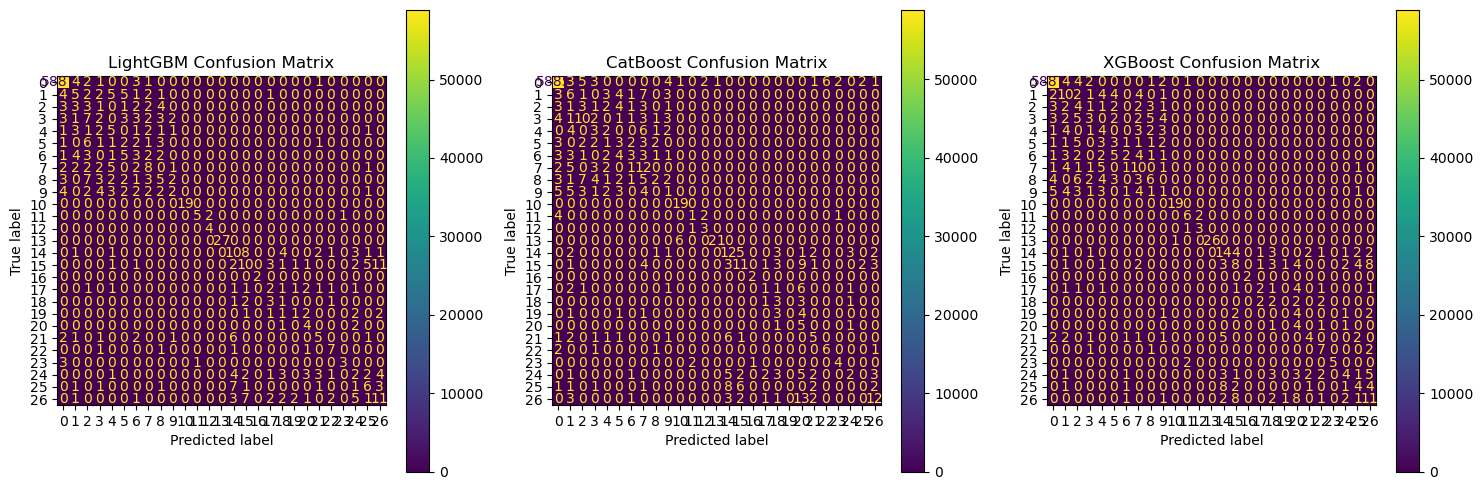

In [42]:
import matplotlib.pyplot as plt

# Confusion Matrix
lgb_cm = confusion_matrix(y_test, lgb_pred_classes)
cat_cm = confusion_matrix(y_test, cat_pred_classes)
xgb_cm = confusion_matrix(y_test, xgb_pred_classes)

# Visualize Confusion Matrix
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ConfusionMatrixDisplay(confusion_matrix=lgb_cm).plot(ax=ax[0])
ax[0].set_title('LightGBM Confusion Matrix')

ConfusionMatrixDisplay(confusion_matrix=cat_cm).plot(ax=ax[1])
ax[1].set_title('CatBoost Confusion Matrix')

ConfusionMatrixDisplay(confusion_matrix=xgb_cm).plot(ax=ax[2])
ax[2].set_title('XGBoost Confusion Matrix')

plt.tight_layout()
plt.show()